<a href="https://colab.research.google.com/github/wiso/TutorialML-AtlasItalia2022/blob/main/notebooks/3.3-VariationalAutoEncoderConditional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
nclasses = 10
# preprocessing
train_images = train_images / 255.
test_images = test_images / 255.

# encode the labels as one hot: an arrays with element equal to one in the index corresponding to the class index, otherwise zero
train_labels_onehot = tf.one_hot(train_labels, nclasses).numpy()
test_labels_onehot = tf.one_hot(test_labels, nclasses).numpy()

4431872/4422102 [==============================] - 0s 0us/step


## The model
The model is similar to the variational autoencoder, but we feed the label as input of the encoder and also as additional variable in the latent space

In [31]:
class Autoencoder(tf.keras.models.Model):
    def __init__(self, latent_dim, nclasses, kl_weight=0.01):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.prior = tfp.distributions.Independent(tfp.distributions.Normal(loc=tf.zeros(latent_dim), scale=1), reinterpreted_batch_ndims=1)

        latent_dim_params = tfp.layers.IndependentNormal.params_size(latent_dim)

        # the convolutional part of the encoder
        self.encoder_conv = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.Flatten(),
        ], name='encoder_conv')

        # concatenate the output of the convolution with the label information
        img = tf.keras.Input(shape=(28, 28, 1), name='image')
        class_onehot = tf.keras.layers.Input(shape=(nclasses, ), name='label')
        x1 = self.encoder_conv(img)
        x1 = tf.concat([x1, class_onehot], axis=-1)
        x1 = tf.keras.layers.Dense(latent_dim_params, activation=None)(x1)
        x1 = tfp.layers.IndependentNormal(
                latent_dim,
                activity_regularizer=tfp.layers.KLDivergenceRegularizer(self.prior, weight=kl_weight))(x1)
        
        self.encoder = tf.keras.Model(inputs=[img, class_onehot], outputs=x1)

        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=[latent_dim + nclasses]),
            tf.keras.layers.Dense(7 * 7 * 64, activation='relu'),
            tf.keras.layers.Reshape((7, 7, 64)),
            tf.keras.layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), padding='SAME', activation='relu'),
            tf.keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), padding='SAME', activation='relu'),
            tf.keras.layers.Conv2DTranspose(1, kernel_size=(3, 3), strides=(1, 1), padding='SAME', activation='sigmoid'),
            tf.keras.layers.Reshape((28, 28))
        ])

    def call(self, x):
        ximg, xlabel = x
        encoded = self.encoder([ximg, xlabel])
        encoded_plus_class = tf.concat([encoded, xlabel], axis=-1)
        decoded = self.decoder(encoded_plus_class)
        return decoded

latent_dim = 2
kl_weight = 0.0002  # with higher latent dim use smaller weight
autoencoder = Autoencoder(latent_dim, nclasses, kl_weight)
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.Huber())

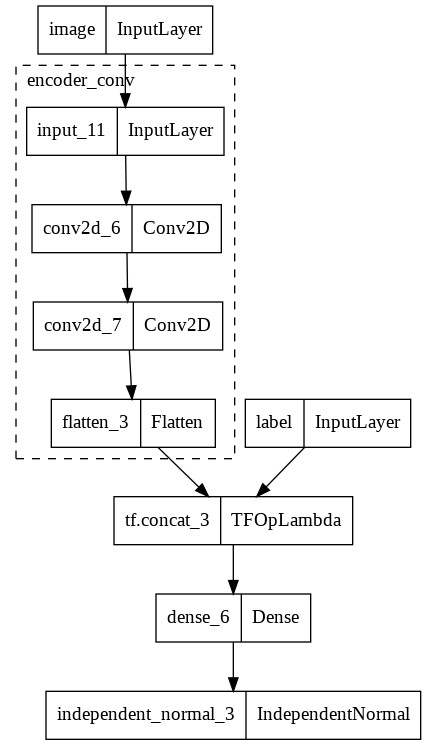

In [32]:
from keras.utils.vis_utils import plot_model
plot_model(autoencoder.encoder, expand_nested=True)

In [33]:
history = autoencoder.fit([train_images, train_labels_onehot], train_images,
                epochs=10,
                batch_size=512,
                validation_data=([test_images, test_labels_onehot], test_images))

Epoch 1/10
118/118 [==============================] - 7s 47ms/step - loss: 0.0402 - val_loss: 0.0271
Epoch 2/10
118/118 [==============================] - 5s 44ms/step - loss: 0.0224 - val_loss: 0.0162
Epoch 3/10
118/118 [==============================] - 5s 44ms/step - loss: 0.0152 - val_loss: 0.0146
Epoch 4/10
118/118 [==============================] - 5s 44ms/step - loss: 0.0142 - val_loss: 0.0140
Epoch 5/10
118/118 [==============================] - 5s 44ms/step - loss: 0.0137 - val_loss: 0.0136
Epoch 6/10
118/118 [==============================] - 5s 44ms/step - loss: 0.0134 - val_loss: 0.0133
Epoch 7/10
118/118 [==============================] - 5s 44ms/step - loss: 0.0131 - val_loss: 0.0131
Epoch 8/10
118/118 [==============================] - 5s 44ms/step - loss: 0.0129 - val_loss: 0.0129
Epoch 9/10
118/118 [==============================] - 5s 44ms/step - loss: 0.0128 - val_loss: 0.0128
Epoch 10/10
118/118 [==============================] - 5s 45ms/step - loss: 0.0127 - val_lo

In [34]:
encoded_imgs = autoencoder.encoder([test_images, test_labels_onehot])
decoded_imgs = autoencoder.decoder(tf.concat([encoded_imgs, test_labels_onehot], axis=-1)).numpy()

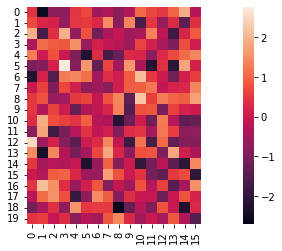

In [35]:
fig, ax = plt.subplots(figsize=(15, 4))
sns.heatmap(encoded_imgs[:20, :], ax=ax, square=True)
plt.show()

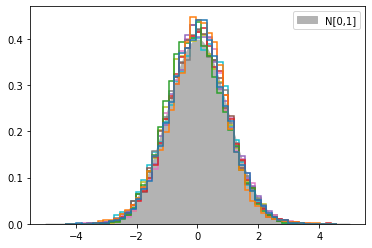

In [36]:
from scipy import stats

fig, ax = plt.subplots()
ax.hist(encoded_imgs.sample().numpy()[:, :10], bins=50, density=True, stacked=False, histtype='step', linewidth=1.5)
xspace = np.linspace(-5, 5, 100)
y = stats.norm(0, 1).pdf(xspace)
ax.fill_between(xspace, y, color='0.7', zorder=-1, label='N[0,1]')
ax.legend()
plt.show()

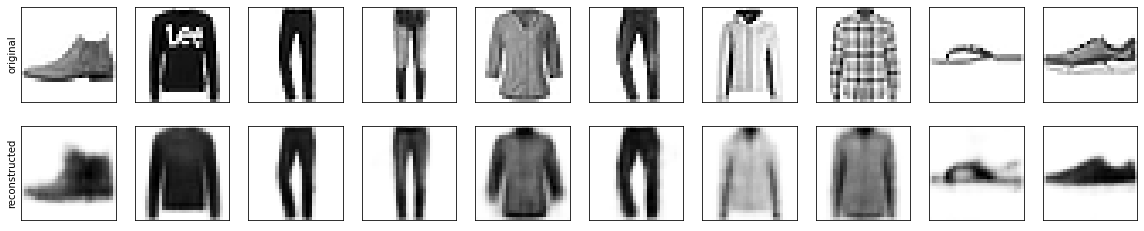

In [37]:
n = 10
fig = plt.figure(figsize=(20, 4))
for i in range(n):
    ax = fig.add_subplot(2, n, i + 1)
    ax.imshow(test_images[i], cmap='binary')
    if i == 0:
      ax.set_ylabel('original')
    
    ax = fig.add_subplot(2, n, i + 1 + n)
    ax.imshow(decoded_imgs[i, :, :], cmap='binary')
    if i == 0:
      ax.set_ylabel('reconstructed')


for ax in fig.get_axes():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

plt.show()

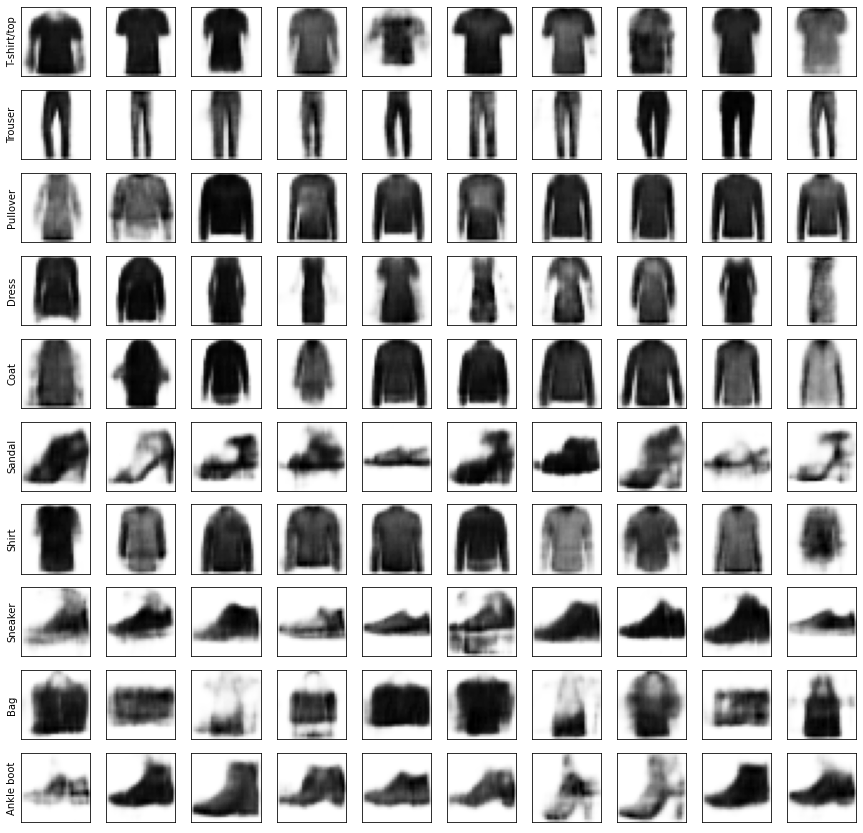

In [44]:
fig, axs = plt.subplots(nclasses, 10, figsize=(15, 15))

for iclass, axs_row in enumerate(axs):
    for ax in axs_row.flat:
        noise = autoencoder.prior.sample()
        class_one_hot = np.zeros(nclasses)
        class_one_hot[iclass] = 1
        noise_plus_class = np.concatenate([noise, class_one_hot])
        noise_plus_class = np.expand_dims(noise_plus_class, axis=0)
        decoded_img = autoencoder.decoder(noise_plus_class).numpy()[0]
        ax.imshow(decoded_img, cmap='binary')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
        if (ax.get_subplotspec().colspan.start == 0):
            ax.set_ylabel(class_names[iclass])

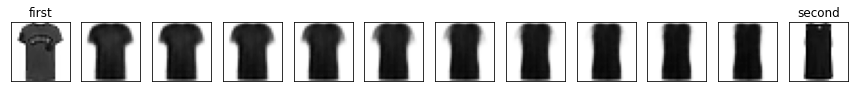

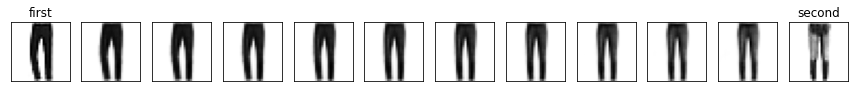

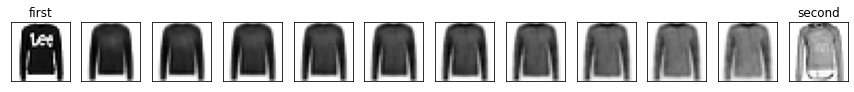

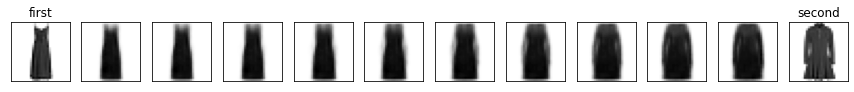

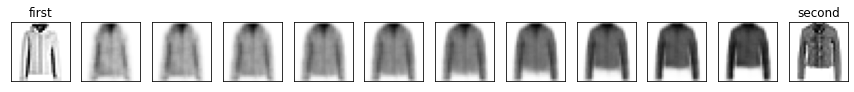

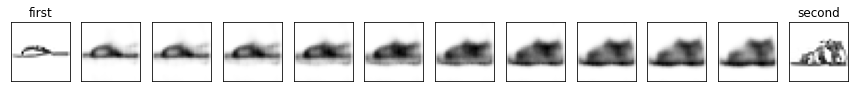

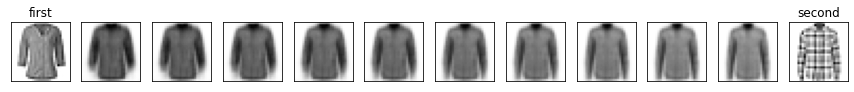

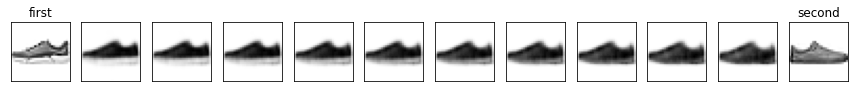

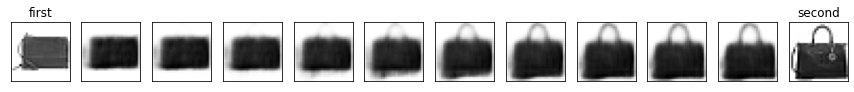

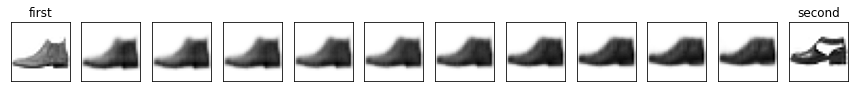

In [39]:
def interpolate_and_show(test_image1, test_image2, test_label1, test_label2, decoder, encoder):
    encoded1, encoded2 = autoencoder.encoder([np.stack([test_image1, test_image2]),
                                              np.stack([test_label1, test_label2])]).mean().numpy()

    t = np.expand_dims(np.linspace(0, 1, 10), axis=-1)
    encoded_steps = encoded1 * (1 - t) + encoded2 * t
    label_steps = test_label1 * (1 - t) + test_label2 * t

    fig, axs = plt.subplots(1, 10 + 2, figsize=(15, 5))

    axs[0].imshow(test_image1, cmap='binary')
    axs[-1].imshow(test_image2, cmap='binary')
    axs[0].set_title('first')
    axs[-1].set_title('second')


    for encoded_step, label_step, ax in zip(encoded_steps, label_steps, axs[1:-1]):
        noise = np.concatenate([encoded_step, label_step])
        img = decoder(np.expand_dims(noise, axis=0)).numpy()[0]
        ax.imshow(img, cmap='binary')

    for ax in axs:    
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')

for ilabel in range(nclasses):
    mask = test_labels == ilabel
    test_image1 = test_images[mask][0]
    test_image2 = test_images[mask][1]
    test_label1 = test_labels_onehot[mask][0]
    test_label2 = test_labels_onehot[mask][1]

    interpolate_and_show(test_image1, test_image2, test_label1, test_label2, autoencoder.decoder, autoencoder.encoder)  

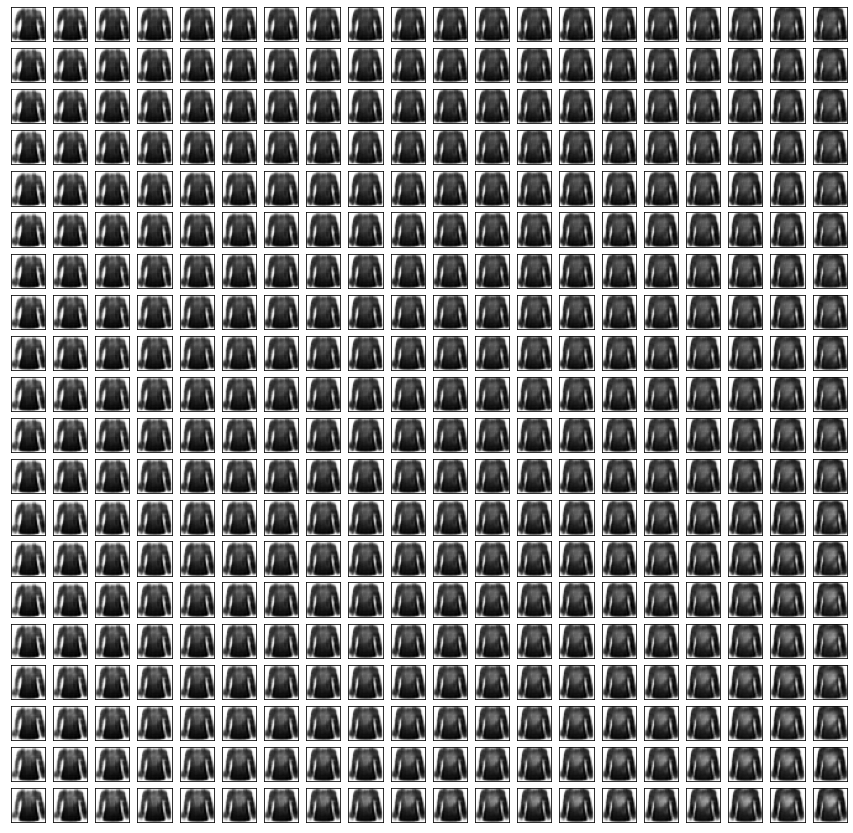

In [40]:
n = 20

fig, axs = plt.subplots(n, ncols=n, figsize=(15, 15))
noise = np.random.multivariate_normal(np.zeros(latent_dim), np.eye(latent_dim))
for inoise1, noise1 in enumerate(np.linspace(0.05, 0.95, n)):
  for inoise2, noise2 in enumerate(np.linspace(0.05, 0.95, n)):
    noise[0] = stats.norm(0, 1).ppf(noise1)
    noise[1] = stats.norm(0, 1).ppf(noise2)
    class_one_hot = np.zeros(nclasses)
    class_one_hot[0] = 1
    noise_plus_class = np.concatenate([noise, class_one_hot])
    decoded_img = autoencoder.decoder(np.expand_dims(noise_plus_class, axis=0)).numpy()[0]
    axs[inoise1, inoise2].imshow(decoded_img, cmap='binary')

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')